In [14]:

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from torchsig.datasets.sigmf import SigmfDataModule
from torchsig.transforms.target_transforms import YOLOLabel
from torchsig.transforms.dataset_transforms import DatasetTransform, DatasetSignal
import torchsig.transforms.functional as F
from torchsig.transforms.base_transforms import Normalize

In [15]:
# You can download SigMF datasets from IQEngine (https://iqengine.org/browser).
# For example, check out the "airbus-sigence" repository on IQEngine.
# Download both the .sigmf-meta and .sigmf-data files for each recording.
# Place both files in the "./sigmf" folder specified below.
# You can add as many SigMF recordings as you want, but note:
# All recordings must currently have the same sample rate for this example to work.

root = "./sigmf"

In [16]:
# custom spectrogram transform with stride factor
class Spectrogram(DatasetTransform):
    """Computes the spectogram of IQ data.

    Attributes:
        fft_size (int): The FFT size (number of bins) in the spectrogram

    """

    def __init__(
        self,
        fft_size: int,
        fft_stride_factor: int = 1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.fft_size = fft_size
        # fft_stride is the number of data points to move or "hop" over when computing the next FF
        self.fft_stride = fft_size // fft_stride_factor

    def __call__(self, signal: DatasetSignal) -> DatasetSignal:
        signal.data = F.spectrogram(
            signal.data,
            self.fft_size,
            self.fft_stride,
        )
        self.update(signal)
        return signal


# Wideband Example

In [17]:
fft_size = 512
fft_stride_factor = 8

transforms = [Normalize(norm=np.inf), Spectrogram(fft_size=fft_size, fft_stride_factor=fft_stride_factor)]
target_transforms = [YOLOLabel()]


# Instantiate the data module
dm = SigmfDataModule(
    root=root,
    dataset="wideband",
    batch_size=2,
    num_workers=0,
    overwrite=True,
    transforms=transforms,
    target_transforms=target_transforms,
    fft_size=fft_size,
    num_iq_samples=fft_size**2 // fft_stride_factor,
)

# Run prepare_data (should create the YAML file)
dm.prepare_data()
dm.setup(stage='fit')

Found 1 matched SigMF file pairs
Converting 1 SigMF files to Zarr format...
Using overlap factor: 0.5 (50.0%)
Processing SIGINT_DAY_DEMO_all_16_Emitter_Noise...
Conversion complete! Created 3286 samples in sigmf/torchsig


Data shape: (512, 505)
Number of signals: 6
Labels:
(6, 0.0070953369140625, 0.3763239929199219, 0.014190673828125, 0.00747664794921875)
(0, 0.00445556640625, 0.866053173828125, 0.0089111328125, 0.0298568603515625)
(4, 0.0285797119140625, 0.5307393005371094, 0.039154052734375, 0.04046693115234375)
(8, 0.258544921875, 0.26756401977539057, 0.0928955078125, 0.10242943115234375)
(2, 0.6241607666015625, 0.7488323791503906, 0.058746337890625, 0.04566685791015625)
(4, 0.8785552978515625, 0.5307393005371094, 0.039154052734375, 0.04046693115234375)


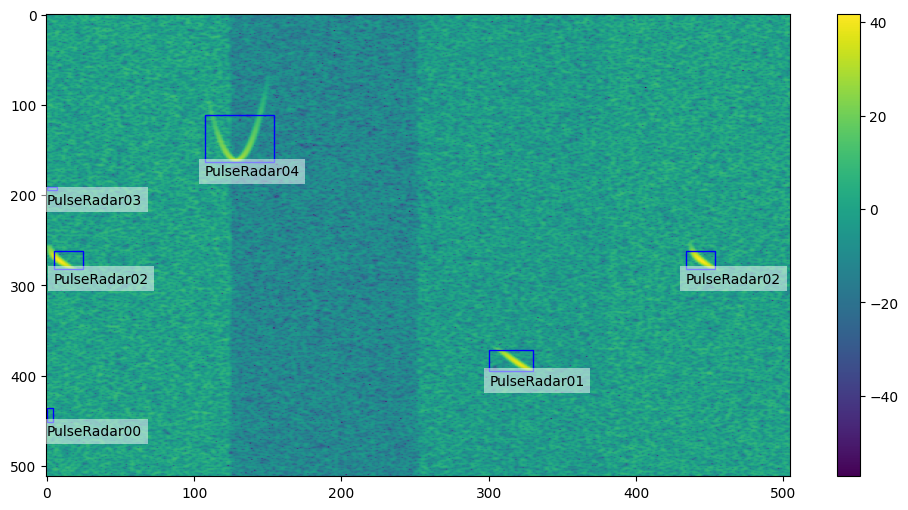

In [18]:
# Access the train dataset
train_dataset = dm.train
# Print dataset information
data, label = train_dataset[34]
print(f"Data shape: {data.shape}")
print(f"Number of signals: {len(label)}")
nl = "\n"
print(f"Labels:\n{nl.join(str(l) for l in label)}")

height, width = data.shape
fig = plt.figure(figsize=(12, 6))
fig.tight_layout()

ax = fig.add_subplot(1, 1, 1)
pos = ax.imshow(data, aspect='auto')

fig.colorbar(pos, ax=ax)


for t in label:
    classindex, xcenter, ycenter, normwidth, normheight = t

    actualwidth = width * normwidth
    actualheight = height * normheight

    actualxcenter = xcenter * width
    actualycenter = ycenter * height

    x_lowerleft = actualxcenter - (actualwidth / 2)
    y_lowerleft = actualycenter + (actualheight / 2)

    # print(x_lowerleft, y_lowerleft, actualwidth, actualheight)

    ax.add_patch(Rectangle(
        (x_lowerleft, y_lowerleft),
        actualwidth,
        -actualheight,
        linewidth=1,
        edgecolor='blue',
        facecolor='none'
    ))

    textDisplay = dm.label_mapping[classindex]
    ax.text(x_lowerleft, y_lowerleft + 15, textDisplay,
            bbox=dict(facecolor='w', alpha=0.5, linewidth=0))

plt.show()


# Narrowband Example

In [19]:
fft_size = 512
fft_stride_factor = 4

transforms = [Normalize(norm=np.inf), Spectrogram(fft_size=fft_size, fft_stride_factor=4)]
target_transforms = [YOLOLabel()]


# Instantiate the data module
dm = SigmfDataModule(
    root=root,
    dataset="narrowband",
    batch_size=2,
    num_workers=0,
    overwrite=True,
    transforms=transforms,
    target_transforms=target_transforms,
    fft_size=fft_size,
    num_iq_samples=8192,
    target_snr_db=5.0,  # Target SNR for narrowband extraction
)

# Run prepare_data (should create the YAML file)
dm.prepare_data()
dm.setup(stage='fit')

Found 1 matched SigMF file pairs
Converting 1 SigMF files to narrowband Zarr format...
Processing SIGINT_DAY_DEMO_all_16_Emitter_Noise...
Found 3286 annotations
Conversion complete! Created 3286 narrowband samples from 3286 annotations in sigmf/torchsig


Sample 11:
  Data shape: (512, 61)
  Label: (4, 0.49993896484375, 0.5307393005371094, 0.1566162109375, 0.04046693115234375)
Sample 12:
  Data shape: (512, 61)
  Label: (8, 0.5, 0.26756401977539057, 0.37158203125, 0.10242943115234375)
Sample 13:
  Data shape: (512, 61)
  Label: (2, 0.49993896484375, 0.7488323791503906, 0.2349853515625, 0.04566685791015625)
Sample 14:
  Data shape: (512, 61)
  Label: (0, 0.49993896484375, 0.866053173828125, 0.2982177734375, 0.0298568603515625)
Sample 15:
  Data shape: (512, 61)
  Label: (8, 0.5, 0.26756401977539057, 0.37158203125, 0.10242943115234375)
Sample 16:
  Data shape: (512, 61)
  Label: (4, 0.49993896484375, 0.5307393005371094, 0.1566162109375, 0.04046693115234375)


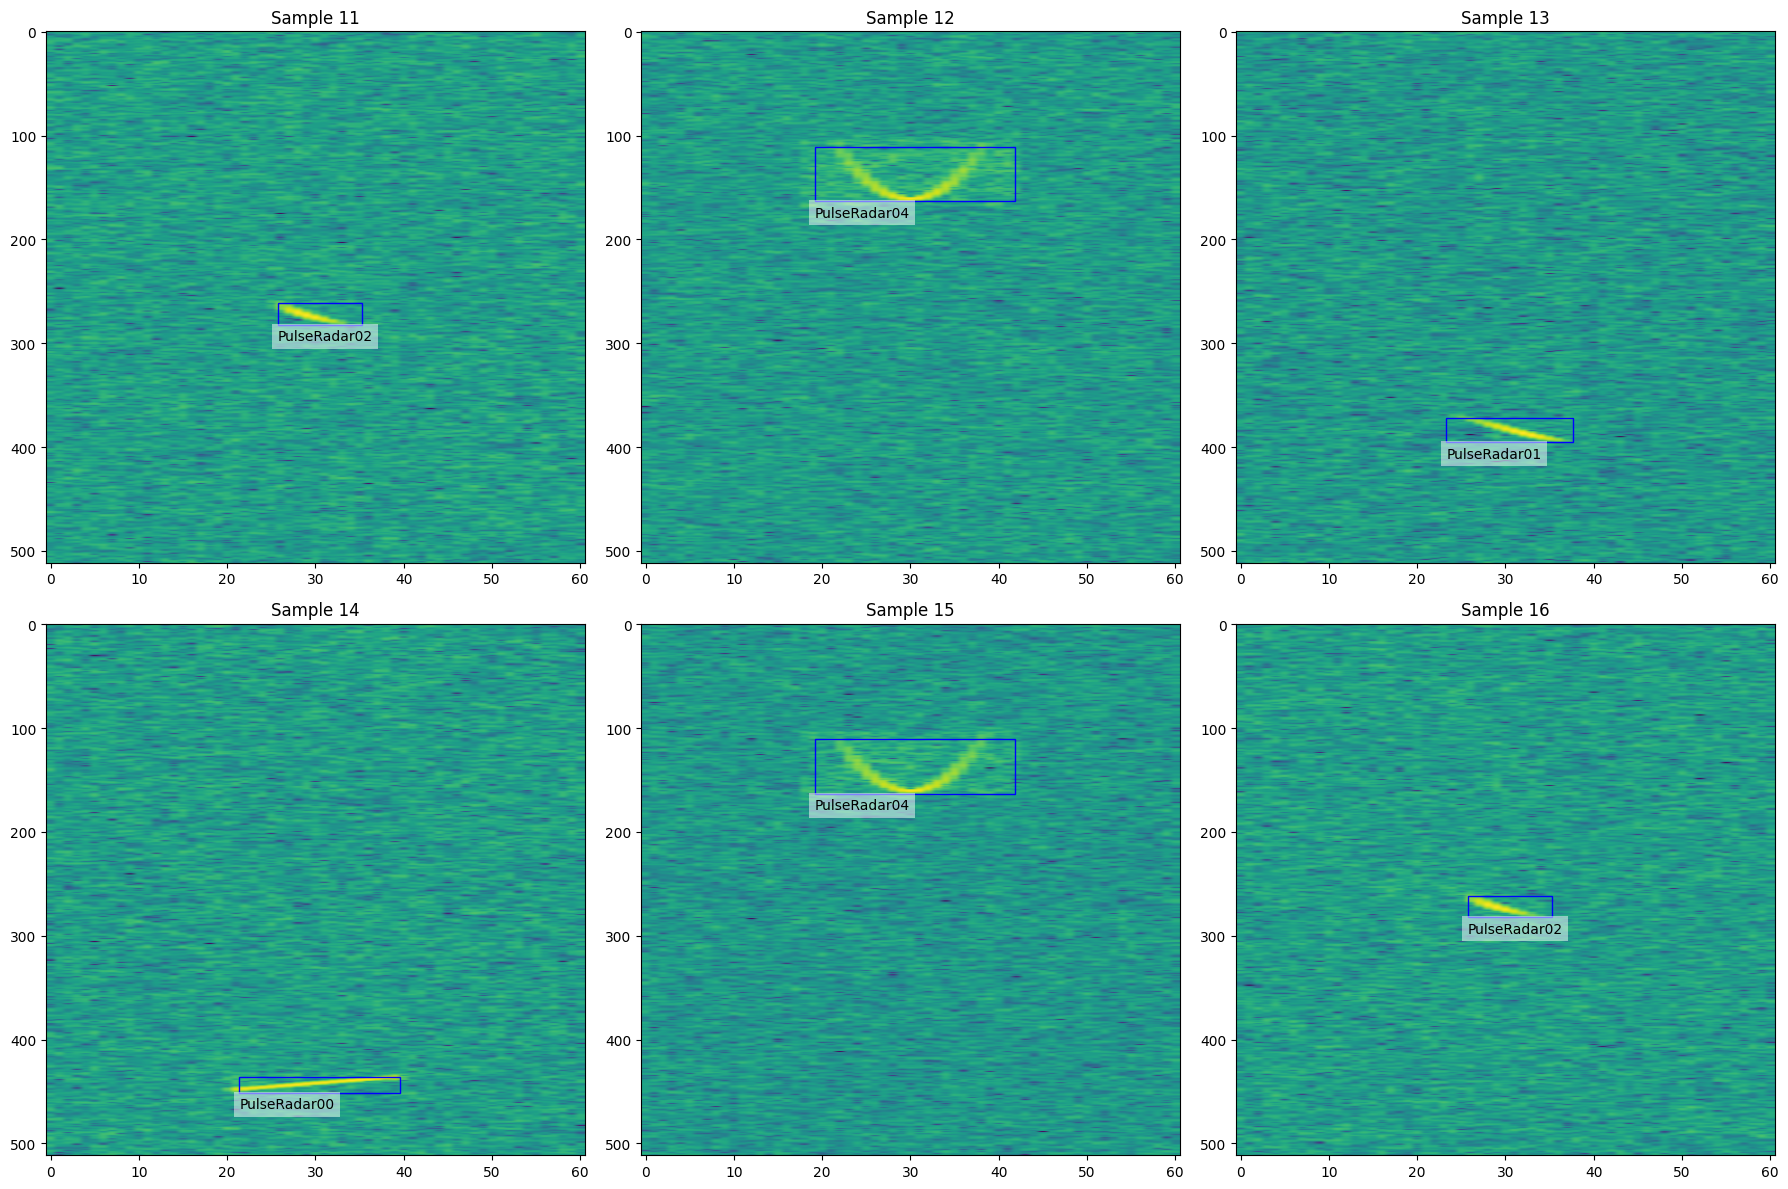

In [20]:
# Access the train dataset
train_dataset = dm.train

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Add offset to see different samples
offset = 11

for sample_idx in range(6):
    data, label = train_dataset[sample_idx + offset]
    ax = axes[sample_idx]
    
    print(f"Sample {sample_idx + offset}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Label: {label}")
    
    pos = ax.imshow(data, aspect='auto')
    ax.set_title(f"Sample {sample_idx + offset}")
    
    # For narrowband, there's only one label (not a list)
    classindex, xcenter, ycenter, normwidth, normheight = label
    
    height, width = data.shape
    actualwidth = width * normwidth
    actualheight = height * normheight
    
    actualxcenter = xcenter * width
    actualycenter = ycenter * height
    
    x_lowerleft = actualxcenter - (actualwidth / 2)
    y_lowerleft = actualycenter + (actualheight / 2)
    
    ax.add_patch(Rectangle(
        (x_lowerleft, y_lowerleft),
        actualwidth,
        -actualheight,
        linewidth=1,
        edgecolor='blue',
        facecolor='none'
    ))
    
    textDisplay = dm.label_mapping[classindex]
    text_y = y_lowerleft + 15  # Shift text down
    ax.text(
        x_lowerleft, text_y, textDisplay,
        bbox=dict(facecolor='w', alpha=0.5, linewidth=0)
    )


plt.tight_layout()
plt.show()